In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
from pathlib import Path
import sys
parentDir = Path.cwd().parent
sys.path.insert(0, str(parentDir))
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
epoch_data_path = parentDir / "data/processed/ninapro_ex1_win200_ms_step50_ms.npz"
save_figs = True

In [3]:
data = np.load(epoch_data_path)

X = data['X']
y = data['y']
subject_ids = data['subject_ids']
rep_ids = data['rep_ids']
t0 = data['t0']
coverage = data['coverage']
Fs = data['Fs']
n_channels = data['n_channels']
L = data['L']
Ld = data['Ld']
T_ms = data['T_ms']
S_ms = data['S_ms']
gesture_ids_all = data['gesture_ids_all']
exercise_number = data['exercise_number']
include_rest = data['include_rest']
majority_threshold = data['majority_threshold']

In [4]:
print(f"Data shape: X={X.shape}, y={y.shape}, rep_ids={rep_ids.shape}, subject_ids={subject_ids.shape}")
print(f"Unique gestures: {np.unique(y)}")
print(f"Unique subjects: {np.unique(subject_ids)}")
print(f"Unique repetitions: {np.unique(rep_ids)}")

Data shape: X=(690099, 12, 400), y=(690099,), rep_ids=(690099,), subject_ids=(690099,)
Unique gestures: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Unique subjects: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Unique repetitions: [0 1 2 3 4 5 6]


### Decicde goals
- goal: cross-subject generalization: train on some subjects, test on held-out subjects
- task: 17-class gesture classification (labels 1...17)

In [5]:
from utils.ml_helpers import set_seeds, get_device
set_seeds(42)
device = get_device()

In [6]:
# Remove rest class (0)
rest_class = 0
select_class_mask = (y != rest_class)
X = X[select_class_mask]
y = y[select_class_mask]
subject_ids = subject_ids[select_class_mask]
rep_ids = rep_ids[select_class_mask]

In [11]:
# splot data for train, test, validation based on subject id
train_percent = 0.7
test_percent = 0.15
val_percent = 0.15

unique_subjects = np.unique(subject_ids)
n_subjects = len(unique_subjects)

n_train = int(n_subjects * train_percent)
n_test = int(n_subjects * test_percent)

# shuffle subjects
shuffled_subjects = unique_subjects.copy()
np.random.shuffle(shuffled_subjects)

train_subjects = shuffled_subjects[:n_train]
test_subjects = shuffled_subjects[n_train:n_train+n_test]
val_subjects = shuffled_subjects[n_train+n_test:]
print(f"Train subjects: {train_subjects}")
print(f"Test subjects: {test_subjects}")
print(f"Validation subjects: {val_subjects}")

# Set train, test, val indices
train_indices = np.isin(subject_ids, train_subjects)
test_indices = np.isin(subject_ids, test_subjects)
val_indices = np.isin(subject_ids, val_subjects)

# X_train, y_train = X[train_indices], y[train_indices]
# X_test, y_test = X[test_indices], y[test_indices]
# X_val, y_val = X[val_indices], y[val_indices]


Train subjects: [20 17 16 27  5 13 38 28 40  7 26 10 14 32 35  9 18 25  1 34  6 12  2 30
 22  3 31 37]
Test subjects: [ 4 36 24 33 11 23]
Validation subjects: [19 21  8 15 29 39]


In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix

In [17]:
class Standardize1D:
    def __init__(self, mean, std):
        self.mean, self.std = mean, std
    def __call__(self, x):
        return (x-self.mean)/self.std

In [18]:
from torch.utils.data import Dataset
class EMGDataset(Dataset):
    def __init__(self,X,y,transform=None):
        self.X=X # keeping as np arrays to save RAM copies
        self.y=y
        self.transform = transform
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self,idx):
        x = torch.from_numpy(self.X[idx]).float() #(C,L)
        y = torch.as_tensor(self.y[idx]).long()
        return x,y


In [ ]:
X_train = X[train_indices]
channel_means_tensor = torch.tensor(X_train.mean(axis=(0,2)), dtype=torch.float32)[:, None]
channel_stds_tensor = torch.tensor(X_train.std(axis=(0,2)).clip(min=1e-8), dtype=torch.float32)[:, None]


# Build dataset with train stats
# 
normalize = Standardize1D(channel_means_tensor, channel_stds_tensor)
train_ds = EMGDataset(X_train, y[train_indices], transform=normalize)
val_ds   = EMGDataset(X[val_indices],  y[val_indices], transform=normalize)
test_ds  = EMGDataset(X[test_indices], y[test_indices], transform=normalize)

In [64]:
# Initialize all hyperparameters in one place
batch_size = 128
num_epochs = 50
learning_rate = 0.001

In [ ]:

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


In [23]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [59]:
class CNN_model(nn.Module):
    """One layer CNN model for EMG:  (B, 12, 400) -> (B, numClasses)
    Conv1d -> BatchNor -> ReLU -> Dropout -> global avg pool -> Linear
    """
    def __init__(self, inChannels:int = 12, numClasses:int = 17, conv1out: int = 64, kernel_size: int = 31, p_dropout: float = 0.2):
        """Arguments:
        inChannels: number of input channels (EMG electrodes)
        numClasses: number of output classes (gestures)
        conv1out: number of filters identified. lower number to reduce overfitting or increase for underfitting
        kernel_size: kernel size or temporal receptive field in samples
        p_dropout: dropout probability"""
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=inChannels, out_channels=conv1out, kernel_size=kernel_size, padding=kernel_size//2)
        self.batchnorm1 = nn.BatchNorm1d(conv1out)
        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=p_dropout)
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1) # output size (B, conv1out, 1) so for each filter we have 1 value
        self.fc = nn.Linear(conv1out, numClasses) # final classification layer

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.global_avg_pool(x) # (B, conv1out, 1)
        x = x.squeeze(-1)           # (B, conv1out)
        x = self.fc(x)              # (B, numClasses)
        return x

def accuracy(logits, y):
    return (logits.argmax(dim=1) == y).float().mean().item()

In [50]:
num_classes = len(np.unique(y))
n_channels, len_of_samples = X_train.shape[1], X_train.shape[2]
print("X shape:", X_train.shape, "| n_channels,len_of_samples=", n_channels, len_of_samples)


X shape: (249159, 12, 400) | n_channels,len_of_samples= 12 400


In [54]:
model = CNN_model(inChannels=n_channels, numClasses=num_classes, kernel_size=31, conv1out=64, p_dropout=0.2)
model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

CNN_model(
  (conv1): Conv1d(12, 64, kernel_size=(31,), stride=(1,), padding=(15,))
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation): ReLU()
  (dropout): Dropout(p=0.2, inplace=False)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=64, out_features=17, bias=True)
)


In [62]:
# One loop of training
def train_one_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train() # Set model to training mode
    running_loss, running_acc, n = 0.0, 0.0, 0
    for batch, (X, y) in enumerate(train_loader): # Loop over batches
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True) # clears old gradients from the last batch

        # Forward pass
        logits = model(X)
        loss = loss_fn(logits, y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        batch_size = X.size(0)
        running_loss += loss.item() * batch_size
        running_acc += accuracy(logits, y) * batch_size
        n += batch_size

        return running_loss / n, running_acc / n


# One loop of validation
def validate_one_epoch(model, val_loader, loss_fn, device):
    model.eval() # Set model to evaluation mode
    running_loss, running_acc, n = 0.0, 0.0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)

            batch_size = X.size(0)
            running_loss += loss.item() * batch_size
            running_acc += accuracy(logits, y) * batch_size
            n += batch_size

    return running_loss / n, running_acc / n

In [65]:
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

best_val_acc = 0.0
bad_epochs = 0
patience = 10
ckpt_path = "smallcnn1d_best.pt"

for epoch in range(num_epochs):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, loss_fn, optimizer, device)
    va_loss, va_acc = validate_one_epoch(model, val_loader, loss_fn, device)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    print(f"Epoch {epoch+1:03d} | "
          f"train: loss {tr_loss:.4f}, acc {tr_acc:.3f} | "
          f"val: loss {va_loss:.4f}, acc {va_acc:.3f}")

    # early stopping on val accuracy
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        bad_epochs = 0
        torch.save(model.state_dict(), ckpt_path)
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping (no val acc improvement for {patience} epochs).")
            break

# load best model before testing/plotting
model.load_state_dict(torch.load(ckpt_path, map_location=device))


Epoch 001 | train: loss 1.5871, acc 0.430 | val: loss 2.1593, acc 0.278
Epoch 002 | train: loss 1.8806, acc 0.328 | val: loss 2.1586, acc 0.279
Epoch 003 | train: loss 1.7493, acc 0.375 | val: loss 2.1618, acc 0.279
Epoch 004 | train: loss 1.6226, acc 0.414 | val: loss 2.1612, acc 0.279
Epoch 005 | train: loss 1.7598, acc 0.391 | val: loss 2.1602, acc 0.279
Epoch 006 | train: loss 1.6881, acc 0.461 | val: loss 2.1630, acc 0.280
Epoch 007 | train: loss 1.7304, acc 0.375 | val: loss 2.1632, acc 0.280
Epoch 008 | train: loss 1.6927, acc 0.375 | val: loss 2.1640, acc 0.280
Epoch 009 | train: loss 1.7416, acc 0.367 | val: loss 2.1619, acc 0.280
Epoch 010 | train: loss 1.8302, acc 0.336 | val: loss 2.1672, acc 0.279
Epoch 011 | train: loss 1.8387, acc 0.320 | val: loss 2.1667, acc 0.278
Epoch 012 | train: loss 1.8983, acc 0.328 | val: loss 2.1619, acc 0.278
Epoch 013 | train: loss 1.8491, acc 0.414 | val: loss 2.1629, acc 0.277
Epoch 014 | train: loss 1.6919, acc 0.375 | val: loss 2.1604, ac

<All keys matched successfully>

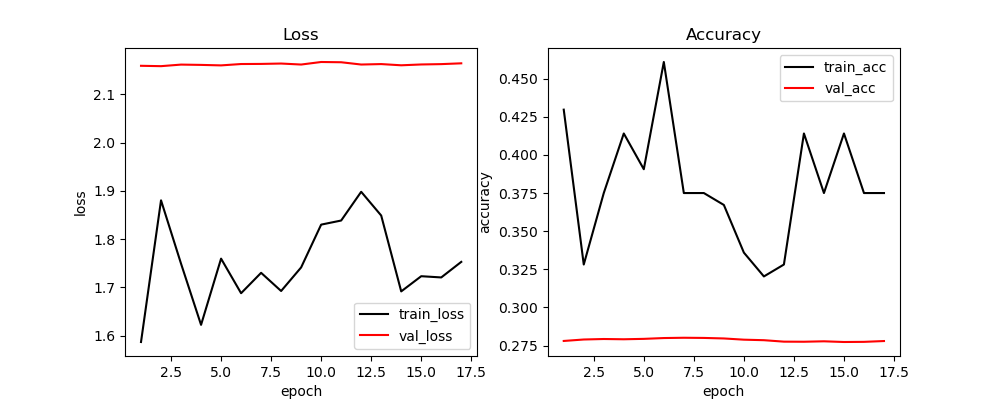

In [68]:
%matplotlib widget
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"])+1)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(epochs, history["train_loss"], label="train_loss", color='black')
axs[0].plot(epochs, history["val_loss"],   label="val_loss", color='red')
axs[0].set_xlabel("epoch"); axs[0].set_ylabel("loss"); axs[0].legend(); axs[0].set_title("Loss")

axs[1].plot(epochs, history["train_acc"], label="train_acc", color='black')
axs[1].plot(epochs, history["val_acc"],   label="val_acc", color='red')
axs[1].set_xlabel("epoch"); axs[1].set_ylabel("accuracy"); axs[1].legend(); axs[1].set_title("Accuracy"); plt.show()
